In [1]:
# Make sure that the package can be imported
import sys
from os.path import expanduser, join
home = expanduser("~")
sys.path.append(join(home, 'Repositories/QuREBB'))
from importlib import reload  # Python 3.4+

import tools.simulation_tools as stools; reload(stools)

import numpy as np
import qutip as qt
import scipy.constants as cst
import matplotlib.pyplot as plt

import h5py as h5
save_path=join(home, 'Repositories/QuREBB/tutorial_simulations/simulation_data/')

import time
from copy import deepcopy

qt.settings.auto_tidyup = False

clr_dict = {
    'dblue': '#2596be',#'#151F30',
    'blue': '#0810b9', #'#103778',
    'lblue': '#8488dc', #'#0593A2',
    'orange': '#FF7A48',
    'dorange': '#E3371E',
    'red': '#972B17',
    'dred': '#651C0F',
    'dprl': '#952b98',
    'lprl': '#b67dd7',
    'vlprl': '#cea9e5'
    
    
}

ModuleNotFoundError: No module named 'tools'

In [ ]:
import matplotlib.ticker as mticker
class AdditionalTickLocator(mticker.Locator):
    '''This locator chains whatever locator given to it, and then add addition custom ticks to the result'''
    def __init__(self, chain: mticker.Locator, ticks) -> None:
        super().__init__()
        assert chain is not None
        self._chain = chain
        self._additional_ticks = np.asarray(list(ticks))

    def _add_locs(self, locs):
        locs = np.unique(np.concatenate([
            np.asarray(locs),
            self._additional_ticks
        ]))
        return locs

    def tick_values(self, vmin, vmax):
        locs = self._chain.tick_values(vmin, vmax)
        return self._add_locs(locs)

    def __call__(self):
        # this will call into chain's own tick_values,
        # so we also add ours here
        locs = self._chain.__call__()
        return self._add_locs(locs)

    def nonsingular(self, v0, v1):
        return self._chain.nonsingular(v0, v1)
    def set_params(self, **kwargs):
        return self._chain.set_params(**kwargs)
    def view_limits(self, vmin, vmax):
        return self._chain.view_limits(vmin, vmax)


class AdditionalTickFormatter(mticker.Formatter):
    '''This formatter chains whatever formatter given to it, and
    then does special formatting for those passed in custom ticks'''
    def __init__(self, chain: mticker.Formatter, ticks) -> None:
        super().__init__()
        assert chain is not None
        self._chain = chain
        self._additional_ticks = ticks

    def __call__(self, x, pos=None):
        if x in self._additional_ticks:
            return self._additional_ticks[x]
        res = self._chain.__call__(x, pos)
        return res

    def format_data_short(self, value):
        if value in self._additional_ticks:
            return self.__call__(value)
        return self._chain.format_data_short(value)

    def get_offset(self):
        return self._chain.get_offset()
    
    def _set_locator(self, locator):
        self._chain._set_locator(locator)

    def set_locs(self, locs):
        self._chain.set_locs(locs)
        
def axis_add_custom_ticks(axis, ticks):
    locator = axis.get_major_locator()
    formatter = axis.get_major_formatter()
    axis.set_major_locator(AdditionalTickLocator(locator, ticks.keys()))
    axis.set_major_formatter(AdditionalTickFormatter(formatter, ticks))

In [4]:
import matplotlib as mpl
# mpl.rcParams.keys()
mpl.rcParams['lines.markeredgecolor'] = (0,0,0,0.5)
mpl.rcParams['lines.markeredgewidth'] = 0.2

# Rate-Fidelity for protocols with standard parameters

In [247]:
## get data

lr_name = 'linear_reflection_sp.h5'
mr_name = 'midpoint_reflection_sp.h5'
em_name = 'midpoint_emission.h5'

lr_wcs_name = 'linear_reflection_wcs.h5'

lr_datafile = h5.File(save_path + lr_name,'r')
mr_datafile = h5.File(save_path + mr_name,'r')
em_datafile = h5.File(save_path + em_name,'r')

lr_wcs_datafile = h5.File(save_path + lr_wcs_name,'r')


In [248]:
#Extract sweep params for Linref
lr_fopers = lr_datafile['sweep_params'].attrs['f_operation'][:]
lr_deltas = lr_datafile['sweep_params'].attrs['delta'][:]

lr_fmap = lr_datafile['data'].get('fidelity_map')[:]
lr_rmap = lr_datafile['data'].get('rate_map')[:]
lr_fcurve = lr_datafile['data'].get('fidelity_curve')[:]
lr_rcurve = lr_datafile['data'].get('rate_curve')[:]


# #Extract sweep params for Midref
mr_fopers = mr_datafile['sweep_params'].attrs['f_operation'][:]
mr_deltas = mr_datafile['sweep_params'].attrs['delta'][:]

mr_fmap = mr_datafile['data'].get('fidelity_map')[:]
mr_rmap = mr_datafile['data'].get('rate_map')[:]
mr_fcurve = mr_datafile['data'].get('fidelity_curve')[:]
mr_rcurve = mr_datafile['data'].get('rate_curve')[:]

#Extract sweep params for Emit
em_alphas = em_datafile['sweep_params'].attrs['alpha'][:]

em_fmap = em_datafile['data'].get('fidelity_map')[:]
em_rmap = em_datafile['data'].get('rate_map')[:]
em_fcurve = em_datafile['data'].get('fidelity_curve')[:]
em_rcurve = em_datafile['data'].get('rate_curve')[:]

#Extract sweep params for Linref WCS
lr_wcs_fopers = lr_wcs_datafile['sweep_params'].attrs['f_operation'][:]
lr_wcs_deltas = lr_wcs_datafile['sweep_params'].attrs['delta'][:]

lr_wcs_fmap = lr_wcs_datafile['data'].get('fidelity_map')[:]
lr_wcs_rmap = lr_wcs_datafile['data'].get('rate_map')[:]
lr_wcs_fcurve = lr_wcs_datafile['data'].get('fidelity_curve')[:]
lr_wcs_rcurve = lr_wcs_datafile['data'].get('rate_curve')[:]


In [249]:
em_datafile.close()
mr_datafile.close()
lr_datafile.close()

lr_wcs_datafile.close()


In [250]:
#redo rf curve for linref

lr_fcurve, lr_rcurve = stools.get_fidelity_rate_curve(lr_fmap, lr_rmap, n=100)
mr_fcurve, mr_rcurve = stools.get_fidelity_rate_curve(mr_fmap, mr_rmap, n=100)

lr_wcs_fcurve, lr_wcs_rcurve = stools.get_fidelity_rate_curve(lr_wcs_fmap, lr_wcs_rmap, n=100)


C:\Users\Matteo Pasini\AppData\Local\Temp\ipykernel_28876\620253150.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  rf_ax.plot(em_rcurve, 1-em_fcurve, '.', label='Protocol A', color=clr_dict['dprl'], marker = 'o')
C:\Users\Matteo Pasini\AppData\Local\Temp\ipykernel_28876\620253150.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  rf_ax.plot(mr_rcurve, 1-mr_fcurve, '.', label='Protocol B', color=clr_dict['dorange'],marker = 'o')
C:\Users\Matteo Pasini\AppData\Local\Temp\ipykernel_28876\620253150.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  rf_ax.plot(lr_rcurve, 1-lr_fcurve, '.', label='Protocol C', color=clr_dict['blue'],marker = 'o')


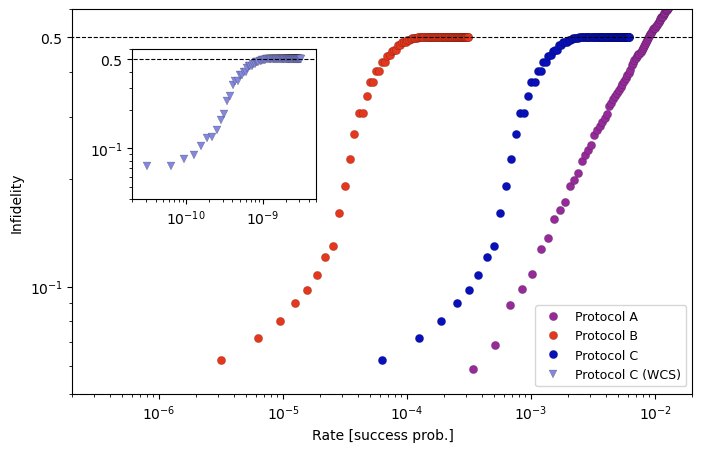

In [286]:
rf_fig, rf_ax = plt.subplots(figsize = (8,5))

figname = 'protocols_comparison_v5_1'


rf_ax.plot(em_rcurve, 1-em_fcurve, '.', label='Protocol A', color=clr_dict['dprl'], marker = 'o')
rf_ax.plot(mr_rcurve, 1-mr_fcurve, '.', label='Protocol B', color=clr_dict['dorange'],marker = 'o')
rf_ax.plot(lr_rcurve, 1-lr_fcurve, '.', label='Protocol C', color=clr_dict['blue'],marker = 'o')


#rf_ax.plot(lr_wcs_rcurve, 1-lr_wcs_fcurve, '.', label='Protocol C with WCS', color=clr_dict['lblue'],marker = 'v')
#rf_ax.plot(mr_wcs_rcurve, 1-mr_wcs_fcurve, label='Midpoint Reflection WCS', color=clr_dict['orange'],linewidth=2, linestyle = '--')



#plot formatting
rf_ax.set_xlabel('Rate [success prob.]')

if False:
    rf_ax.set_ylabel('Infidelity')
    rf_ax.set_yscale('linear')
else:
    rf_ax.set_ylabel('Infidelity')
    rf_ax.set_yscale('log')

#rf_ax.scatter(lr_rcurve[10], lr_fcurve[10], s=200, marker='+', color='k', linewidth=1.5)

rf_ax.set_xscale('log')



rf_ax.hlines(0.5, 1e-8,0.1, 'k', linestyle = '--', linewidth = 0.8)

rf_ax.set_ylim(5e-2,0.6)
rf_ax.set_xlim(2e-7,2e-2)

left, bottom, width, height = [0.2, 0.5, 0.23, 0.3]
wcs_ax = rf_fig.add_axes([left, bottom, width, height])
wcs_ax.plot(lr_wcs_rcurve, 1-lr_wcs_fcurve, '.', label='Protocol C (WCS)', color=clr_dict['lblue'],marker = 'v')
#wcs_ax.set_ylabel('Infidelity')
wcs_ax.set_xscale('log')
wcs_ax.set_yscale('log')
wcs_ax.set_ylim(4e-2,0.6)
wcs_ax.set_xlim(2e-11,5e-9)
wcs_ax.hlines(0.5, 1e-12,0.1, 'k', linestyle = '--', linewidth = 0.8)


rf_fig.legend(loc=1, bbox_to_anchor=(0.9, 0.3), fontsize=9)


axis_add_custom_ticks(rf_ax.yaxis, {
    0.5: '0.5'
})

axis_add_custom_ticks(wcs_ax.yaxis, {
    0.5: '0.5'
})

rf_fig.savefig(figure_path + figname + '.pdf')

# Cooperativity-sweep plots

In [328]:
ksweep_name =  'linear_reflection_coop_sweep_kappa.h5'

gsweep_name = 'linear_reflection_coop_sweep_g.h5'

ksweep_datafile = h5.File(save_path + ksweep_name,'r')
gsweep_datafile = h5.File(save_path + gsweep_name,'r')

c_sweep = np.array([1, 10, 50, 100, 200, 500, 1000]) 


In [329]:
ksweep_keys = list(ksweep_datafile.keys())[:]
print(ksweep_keys)

coops = [int(x[2:]) for x in ksweep_keys]

ksweep_keys = [f"c_{x}" for x in np.sort(coops) ]

ksweep_fmap = []
ksweep_rmap = []
ksweep_fcurve = []
ksweep_rcurve = []
for c in ksweep_keys:
    ksweep_fmap.append(ksweep_datafile[c]['data']['fidelity_map'][:])
    ksweep_rmap.append(ksweep_datafile[c]['data']['rate_map'][:])
    ksweep_fcurve.append(ksweep_datafile[c]['data']['fidelity_curve'][:])
    ksweep_rcurve.append(ksweep_datafile[c]['data']['rate_curve'][:])

gsweep_keys = ksweep_keys# list(gsweep_datafile.keys())[:]

gsweep_fmap = []
gsweep_rmap = []
gsweep_fcurve = []
gsweep_rcurve = []
for c in gsweep_keys:
    gsweep_fmap.append(gsweep_datafile[c]['data']['fidelity_map'][:])
    gsweep_rmap.append(gsweep_datafile[c]['data']['rate_map'][:])
    gsweep_fcurve.append(gsweep_datafile[c]['data']['fidelity_curve'][:])
    gsweep_rcurve.append(gsweep_datafile[c]['data']['rate_curve'][:])
    


for i in range(len(ksweep_keys)):
    fr1 = stools.get_fidelity_rate_curve(ksweep_fmap[i], ksweep_rmap[i], n=200)
    ksweep_fcurve[i] = fr1[0]
    ksweep_rcurve[i] = fr1[1]

for i in range(len(gsweep_keys)):
    fr1 = stools.get_fidelity_rate_curve(gsweep_fmap[i], gsweep_rmap[i], n=200)
    gsweep_fcurve[i] = fr1[0]
    gsweep_rcurve[i] = fr1[1]


['c_0', 'c_1', 'c_10', 'c_100', 'c_200', 'c_5', 'c_50', 'c_500']


In [290]:
clr_reds = ['#EF745C', '#D46458', '#BA5553', '#9F454F', '#84364A', '#692646', '#4F1741', '#34073D']

clr_blues = ['#78CAF7', '#6BB1DF', '#5D99C7', '#5080AF', '#436796', '#364E7E', '#283666', '#1B1D4E']

ckey = ['lblue', 'blue', 'dblue', 'lprl', 'dprl', 'orange', 'red', 'dred']

C:\Users\Matteo Pasini\AppData\Local\Temp\ipykernel_28876\1567638354.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(ksweep_rcurve[i], 1-ksweep_fcurve[i], '.', label='C = {:.0f}'.format(int(c_sweep[i])), color=clr_blues[i], marker = '.', linestyle='-')


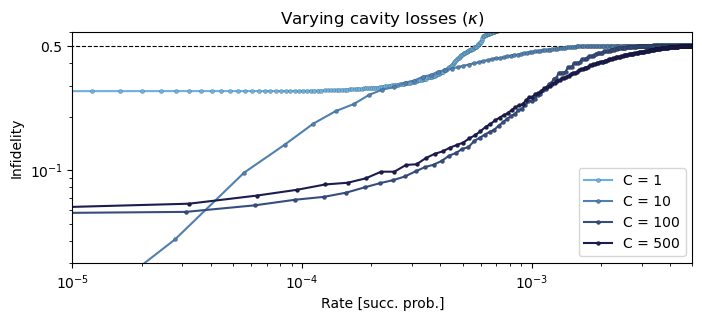

In [298]:
import matplotlib.colors as colors
figname = 'linref_kappa_sweep_light'
fig, ax = plt.subplots(figsize=(8,3))
ax.hlines(0.5, 1e-6,0.1, 'k', linestyle = '--', linewidth = 0.8)

for i in range(len(ksweep_keys))[1::2]:
    ax.plot(ksweep_rcurve[i], 1-ksweep_fcurve[i], '.', label='C = {:.0f}'.format(int(c_sweep[i])), color=clr_blues[i], marker = '.', linestyle='-')


ax.set_xlabel('Rate [succ. prob.]')
ax.set_ylabel('Infidelity')
ax.set_title(r"Varying cavity losses ($\kappa$)")
plt.yscale('log')
plt.xscale('log')

ax.set_xlim(1e-5, 5e-3)
ax.set_ylim(3e-2, 0.6)
ax.legend(loc=4, )

axis_add_custom_ticks(ax.yaxis, {
    0.5: '0.5'
})

C:\Users\Matteo Pasini\AppData\Local\Temp\ipykernel_28876\796216548.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax.plot(gsweep_rcurve[i], 1-gsweep_fcurve[i], '.', label='C = {:.0f}'.format(c_sweep[i]), color=clr_reds[i], marker = '.', linestyle='-')


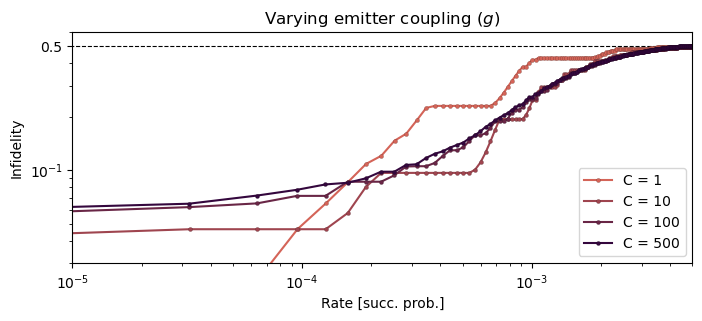

In [297]:
fig, ax = plt.subplots(figsize = (8,3))
figname = 'linref_g_sweep_light'

ax.hlines(0.5, 1e-6,0.1, 'k', linestyle = '--', linewidth = 0.8)

for i in range(len(gsweep_keys))[1::2]:
    ax.plot(gsweep_rcurve[i], 1-gsweep_fcurve[i], '.', label='C = {:.0f}'.format(c_sweep[i]), color=clr_reds[i], marker = '.', linestyle='-')

ax.set_xlabel('Rate [succ. prob.]')
ax.set_ylabel('Infidelity')
ax.set_title(r"Varying emitter coupling ($g$)")
#plt.xlim(1e-6,0.1)
plt.yscale('log')
plt.xscale('log')
ax.set_xlim(1e-5, 5e-3)
ax.set_ylim(3e-2, 0.6)

ax.legend(loc=4, )
axis_add_custom_ticks(ax.yaxis, {
    0.5: '0.5'
})


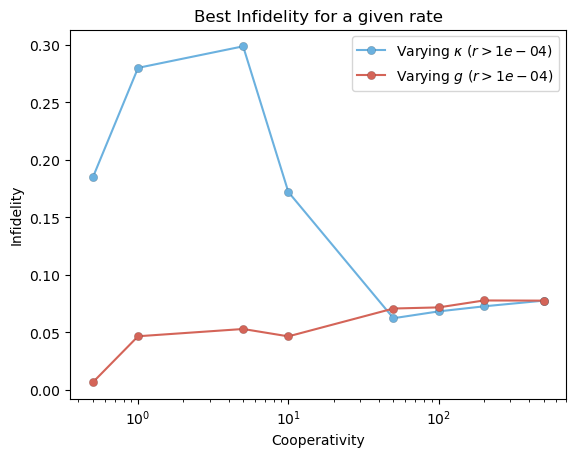

In [304]:
minimum_rate = 1e-4
figname = 'best_infidelity_cooperativity_onerate'
ksweep_fmax = []
gsweep_fmax = []
c=[]

for i, key in enumerate(ksweep_keys):
    ksweep_fmax.append(stools.get_best_fidelity_for_rate(ksweep_fmap[i], ksweep_rmap[i], rate=minimum_rate))
    gsweep_fmax.append(stools.get_best_fidelity_for_rate(gsweep_fmap[i], gsweep_rmap[i], rate=minimum_rate))
    c.append(float(ksweep_keys[i][2:]))

ksweep_fmax_2 = []
gsweep_fmax_2 = []

minimum_rate_2 = 1e-5

for i, key in enumerate(ksweep_keys):
    ksweep_fmax_2.append(stools.get_best_fidelity_for_rate(ksweep_fmap[i], ksweep_rmap[i], rate=minimum_rate_2))
    gsweep_fmax_2.append(stools.get_best_fidelity_for_rate(gsweep_fmap[i], gsweep_rmap[i], rate=minimum_rate_2))
    
fig2, ax2 = plt.subplots()

ax2.plot(c_sweep, 1-np.array(ksweep_fmax), '-o', color = clr_blues[1], label = r"Varying $\kappa$ ($r > {:.0e}$)".format(minimum_rate))
ax2.plot(c_sweep, 1-np.array(ksweep_fmax_2), '-v', color = clr_blues[4], label = r"Varying $\kappa$ ($r > {:.0e}$)".format(minimum_rate_2))
ax2.plot(c_sweep, 1-np.array(gsweep_fmax), '-o', color = clr_reds[1], label = r"Varying $g$ ($r > {:.0e}$)".format(minimum_rate))
ax2.plot(c_sweep, 1-np.array(gsweep_fmax_2), '-v', color = clr_reds[4], label = r"Varying $g$ ($r > {:.0e}$)".format(minimum_rate_2))
ax2.set_yscale('linear')
ax2.set_xscale('log')
ax2.set_title(r"Best Infidelity for a given rate")
ax2.set_xlabel("Cooperativity")
ax2.set_ylabel("Infidelity")

ax2.legend()

fig2.savefig(figure_path + ksweep_name[:15] + '_and_' + gsweep_name[:15] + '_' + figname + '.pdf')